In [2]:
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
from yaml import dump, load, safe_load

In [3]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [4]:
pd.set_option('expand_frame_repr', True)
pd.set_option('colheader_justify', 'right')
pd.set_option('precision', 4)

pd.set_option('max_rows', 100)
pd.set_option('display.width', 200)
pd.set_option('max_columns', 100)
pd.set_option('max_colwidth', 50)
pd.set_option('column_space', 50)

In [5]:
log_path = "logs/"
log_file = "ts_decomposition.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [6]:
sys.path.append("../../sql")
import queries

In [7]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [8]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

# get_nsr_rows = queries.select_nsr_rows
# year1 = "2020"
# year2 = "2015"
# zipcode = "74145"

In [9]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [10]:
zipcode_index = 0

select_nsr_rows = f"""
SELECT date_time, year, zipcode,
Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature, Relative_Humidity from nsrdb
where zipcode = {distinct_zipcodes[zipcode_index]};
"""

df = pd.read_sql(
    # get_nsr_rows,
    select_nsr_rows,
    conn,
    # params={"zipcode": zipcode, "year1": year1, "year2": year2},
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
df

,year,zipcode,Clearsky_DHI,DHI,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity
date_time,,,,,,,,,,
1998-01-01 00:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,65.10
1998-01-01 01:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,61.26
1998-01-01 02:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,58.23
1998-01-01 03:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,56.02
1998-01-01 04:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,53.99
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:30:00,2020,91708,0.0,0.0,0.0,0.0,0.0,0.0,8.9,59.76
2020-12-31 20:30:00,2020,91708,0.0,0.0,0.0,0.0,0.0,0.0,8.2,60.02
2020-12-31 21:30:00,2020,91708,0.0,0.0,0.0,0.0,0.0,0.0,7.6,60.17


In [11]:
a_year_1 = 2018
a_year_2 = 2020
df_a = df[(df['year']>=a_year_1) & (df['year']<=a_year_2)].resample("M").mean().reset_index(drop=False)
df_a.set_index("date_time", inplace=True)

b_year_1 = 2000
b_year_2 = 2002
df_b = df[(df['year']>=b_year_1) & (df['year']<=b_year_2)].resample("M").mean().reset_index(drop=False)
df_b.set_index("date_time", inplace=True)

In [12]:
period=12
feature = "Temperature" # "Relative_Humidity" # "GHI"
decomp_a = seasonal_decompose(df_a[feature], model="additive", period=period)
decomp_b = seasonal_decompose(df_b[feature], model="additive", period=period)

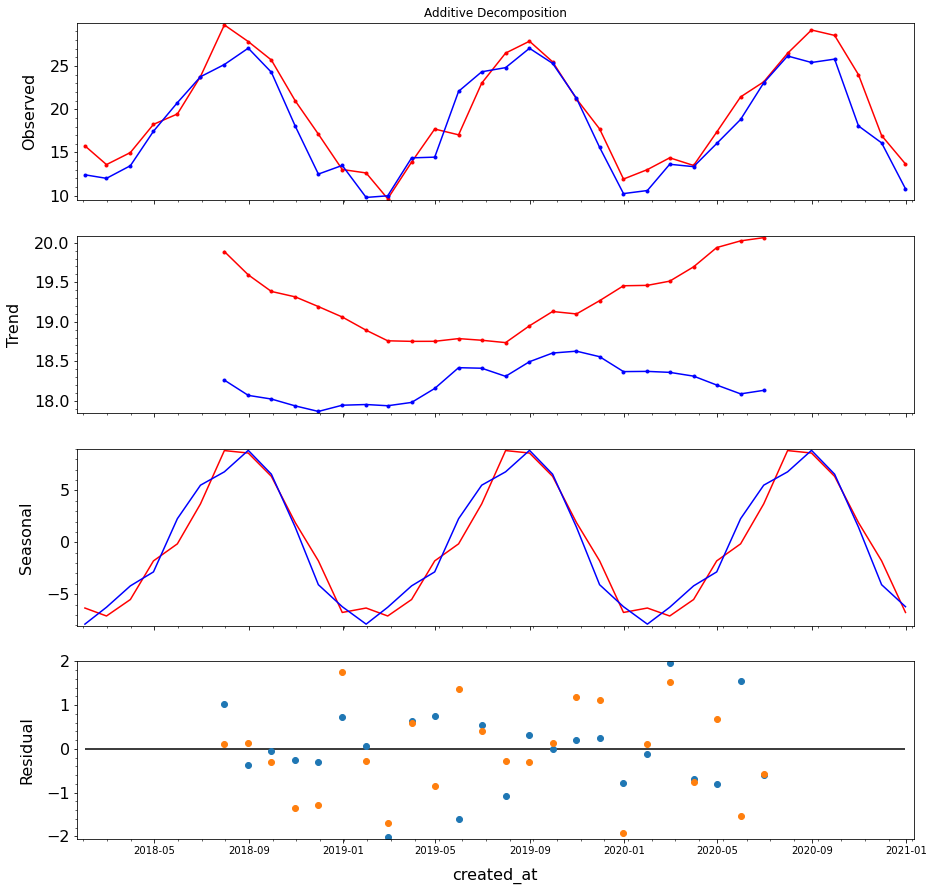

In [16]:
plt.rcParams["figure.figsize"] = 15, 15

fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title("Additive Decomposition")

ax[0].plot(decomp_a.observed.index, decomp_a.observed, '.-', color='red')
ax[0].plot(decomp_a.observed.index, decomp_b.observed, '.-', color='blue')
ax[0].minorticks_on()
ax[0].set(ylabel="Observed")

ax[1].plot(decomp_a.trend.index, decomp_a.trend, '.-', color='red')
ax[1].plot(decomp_a.trend.index, decomp_b.trend, '.-', color='blue')
ax[1].minorticks_on()
ax[1].set(ylabel="Trend")

ax[2].plot(decomp_a.seasonal.index, decomp_a.seasonal, color='red')
ax[2].plot(decomp_a.seasonal.index, decomp_b.seasonal, color='blue')
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")

ax[3].plot(decomp_a.resid.index, decomp_a.resid, "o")
ax[3].plot(decomp_a.resid.index, decomp_b.resid, "o")
ax[3].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()

In [18]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time, year, zipcode,
Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature, Relative_Humidity,
Wind_Speed, Precipitable_Water
from nsrdb
where zipcode = :zipcode;
"""

df_ = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df_.sort_index(axis=0, inplace=True)
df_.head(5)

,year,zipcode,Clearsky_DHI,DHI,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Wind_Speed,Precipitable_Water
date_time,,,,,,,,,,,,
1998-01-01 00:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,65.10,1.0,1.548
1998-01-01 01:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,61.26,1.0,1.468
1998-01-01 02:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,58.23,1.0,1.405
1998-01-01 03:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,56.02,1.1,1.367
1998-01-01 04:30:00,1998,91708,0.0,0.0,0.0,0.0,0.0,0.0,13.0,53.99,1.1,1.361


In [19]:
df_ = df_.resample("M").mean().reset_index(drop=False)
df_.set_index("date_time", inplace=True)

In [20]:
df_.head(24)

,year,Clearsky_DHI,DHI,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Wind_Speed,Precipitable_Water
date_time,,,,,,,,,,,
1998-01-31,1998.0,26.8347,34.2554,312.7258,193.2567,158.5591,116.2688,11.4610,74.9013,1.4087,1.1960
1998-02-28,1998.0,34.0446,47.0387,330.1652,171.0670,201.4360,136.3988,10.0074,86.4792,2.1501,1.4252
1998-03-31,1998.0,46.2594,57.7446,365.6425,219.2325,261.4422,187.1935,12.8589,76.2662,1.9109,1.2709
1998-04-30,1998.0,57.3556,71.6847,384.6417,292.6042,313.8736,268.3472,13.6681,72.9960,1.9069,1.1378
1998-05-31,1998.0,65.3817,88.0094,399.0228,244.4906,345.9220,257.6935,14.9395,79.6353,2.0552,1.4708
1998-06-30,1998.0,62.9056,73.8236,420.5944,298.4486,359.7528,285.7028,18.9569,75.1880,1.9812,1.6951
1998-07-31,1998.0,58.2003,67.0040,422.3374,367.2191,350.6922,324.4852,25.6075,55.6496,1.6497,2.1189
1998-08-31,1998.0,56.4583,59.4812,383.0780,360.9745,315.5672,305.7110,28.6250,45.8215,1.5989,2.7605
1998-09-30,1998.0,50.5681,63.7917,356.2028,237.0819,272.2056,210.8875,22.7694,62.4619,1.6235,2.1454


In [21]:
period=12

feature_a = "Clearsky_DNI"
decomp_a= seasonal_decompose(df_[feature_a], model="additive", period=period)

feature_b = "DNI"
decomp_b = seasonal_decompose(df_[feature_b], model="additive", period=period)

feature_c = "Clearsky_GHI"
decomp_c = seasonal_decompose(df_[feature_c], model="additive", period=period)

feature_d = "GHI"
decomp_d = seasonal_decompose(df_[feature_d], model="additive", period=period)

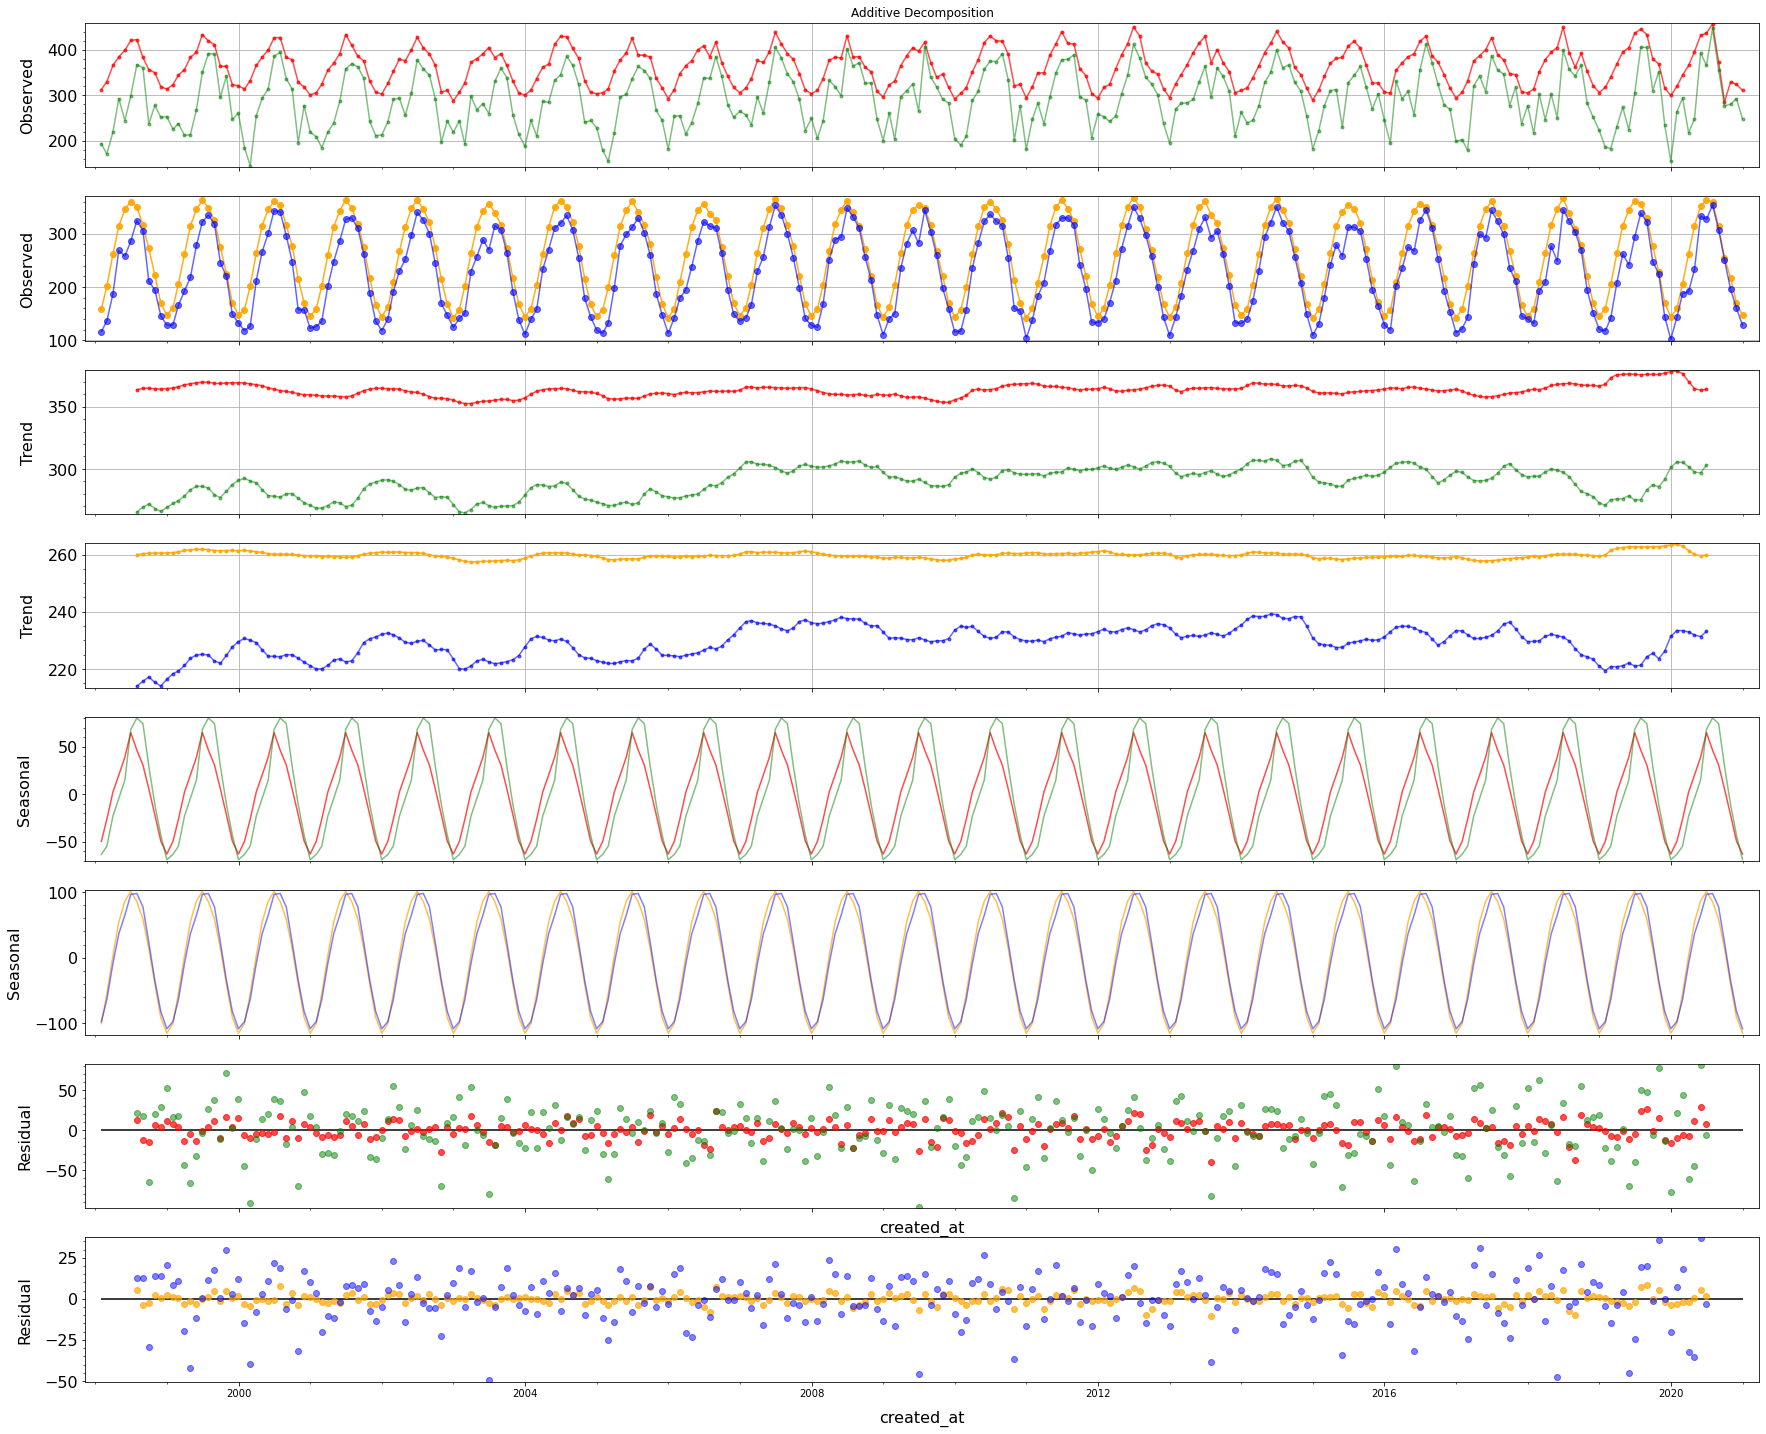

In [22]:
plt.rcParams["figure.figsize"] = 30, 25
fig, ax = plt.subplots(8, sharex=True)
ax[0].set_title("Additive Decomposition")

ax[0].plot(decomp_a.observed.index, decomp_a.observed, '.-', color='red', alpha=.7)
ax[0].plot(decomp_b.observed.index, decomp_b.observed, '.-', color='green', alpha=.5)
ax[0].minorticks_on()
ax[0].grid()
ax[0].set(ylabel="Observed")

ax[1].plot(decomp_c.observed.index, decomp_c.observed, 'o-', color='orange', alpha=.9)
ax[1].plot(decomp_d.observed.index, decomp_d.observed, 'o-', color='blue', alpha=.6)
ax[1].minorticks_on()
ax[1].grid()
ax[1].set(ylabel="Observed")

ax[2].plot(decomp_a.trend.index, decomp_a.trend, '.-', color='red', alpha=.7)
ax[2].plot(decomp_b.trend.index, decomp_b.trend, '.-', color='green', alpha=.5)
ax[2].minorticks_on()
ax[2].grid()
ax[2].set(ylabel="Trend")

ax[3].plot(decomp_c.trend.index, decomp_c.trend, '.-', color='orange', alpha=.9)
ax[3].plot(decomp_d.trend.index, decomp_d.trend, '.-', color='blue', alpha=.6)
ax[3].minorticks_on()
ax[3].grid()
ax[3].set(ylabel="Trend")


ax[4].plot(decomp_a.seasonal.index, decomp_a.seasonal, color='red', alpha=.7)
ax[4].plot(decomp_b.seasonal.index, decomp_b.seasonal, color='green', alpha=.5)
ax[4].minorticks_on()
ax[4].set(ylabel="Seasonal")

ax[5].plot(decomp_c.seasonal.index, decomp_c.seasonal, color='orange', alpha=.7)
ax[5].plot(decomp_d.seasonal.index, decomp_d.seasonal, color='blue', alpha=.5)
ax[5].minorticks_on()
ax[5].set(ylabel="Seasonal")


ax[6].plot(decomp_a.resid.index, decomp_a.resid, "o", color='red', alpha=.7)
ax[6].plot(decomp_b.resid.index, decomp_b.resid, "o", color='green', alpha=.5)
ax[6].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[6].minorticks_on()
ax[6].set(xlabel="created_at", ylabel="Residual")

ax[7].plot(decomp_c.resid.index, decomp_c.resid, "o", color='orange', alpha=.7)
ax[7].plot(decomp_d.resid.index, decomp_d.resid, "o", color='blue', alpha=.5)
ax[7].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[7].minorticks_on()
ax[7].set(xlabel="created_at", ylabel="Residual")

plt.show()

In [23]:
neg = decomp_b.resid[decomp_b.resid<0].sum()
pos = decomp_b.resid[decomp_b.resid>0].sum()
print(f"neg: {neg}, pos: {pos}")

neg: -3460.1354083840038, pos: 3499.916146696086


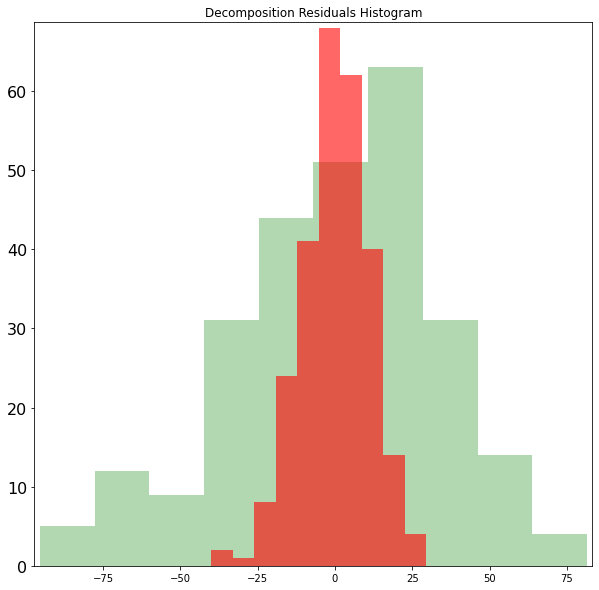

In [27]:
plt.rcParams["figure.figsize"] = 10, 10
fig, ax = plt.subplots(1, sharex=True)
ax.set_title("Decomposition Residuals Histogram")

ax.hist(decomp_b.resid, color='green', alpha=.3)
ax.hist(decomp_a.resid, color='red', alpha=.6)

plt.show()

In [25]:
neg = decomp_d.resid[decomp_d.resid<0].sum()
pos = decomp_d.resid[decomp_d.resid>0].sum()
print(f"neg: {neg}, pos: {pos}")

neg: -1528.9310795702825, pos: 1546.4382744031686


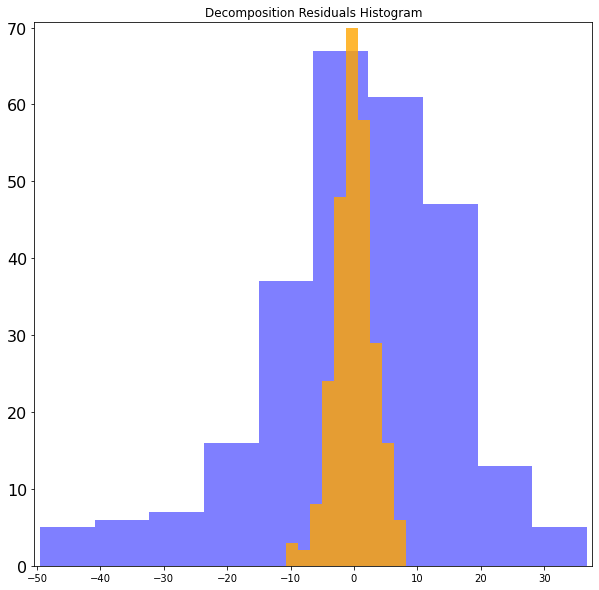

In [28]:
plt.rcParams["figure.figsize"] = 10, 10
fig, ax = plt.subplots(1, sharex=True)
ax.set_title("Decomposition Residuals Histogram")

ax.hist(decomp_d.resid, color='blue', alpha=.5)
ax.hist(decomp_c.resid, color='orange', alpha=.8)

plt.show()

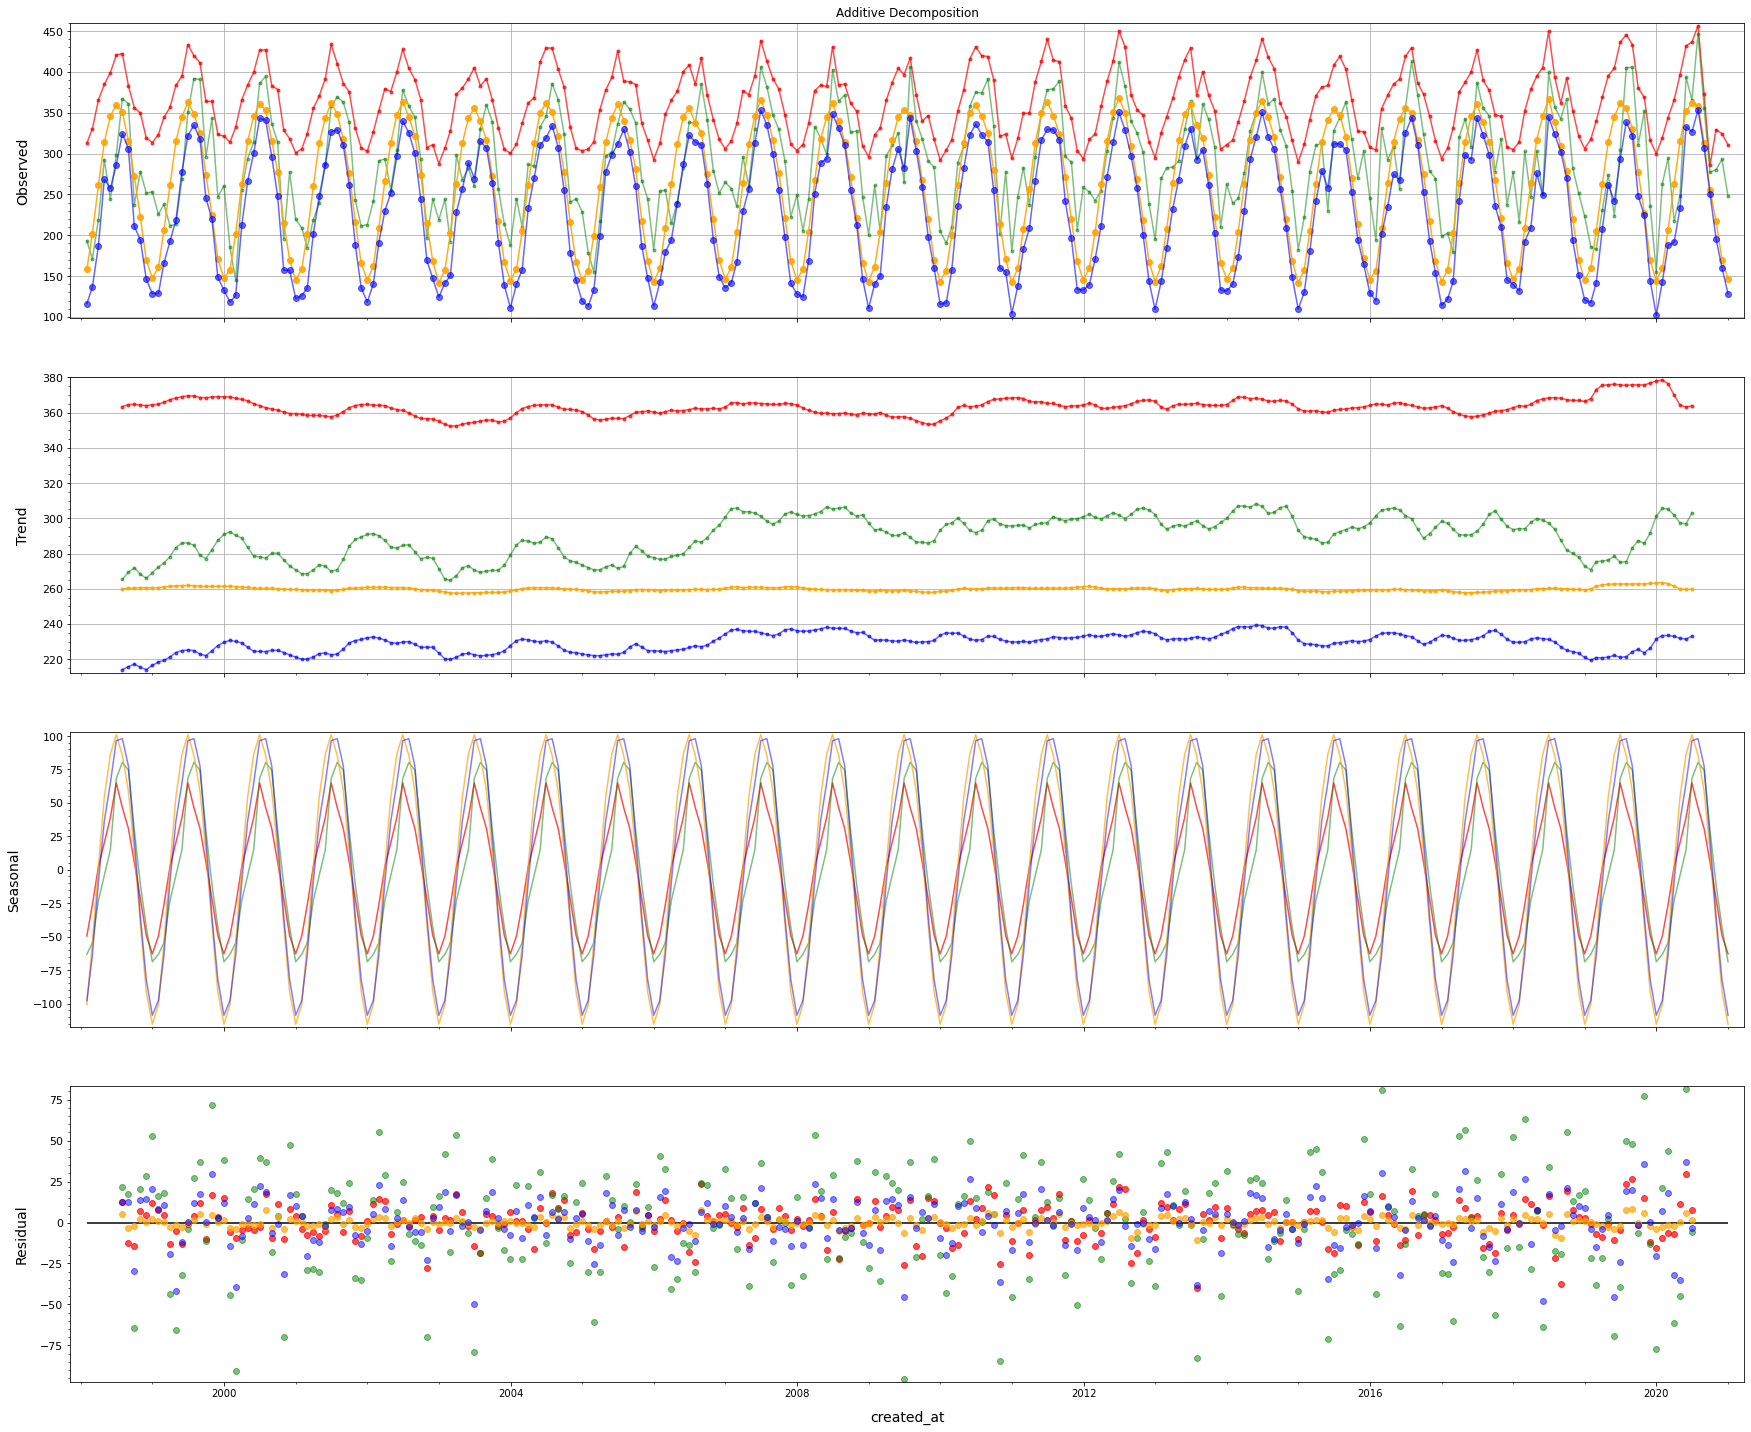

In [26]:
fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title("Additive Decomposition")

ax[0].plot(decomp_a.observed.index, decomp_a.observed, '.-', color='red', alpha=.7)
ax[0].plot(decomp_b.observed.index, decomp_b.observed, '.-', color='green', alpha=.5)
ax[0].plot(decomp_c.observed.index, decomp_c.observed, 'o-', color='orange', alpha=.9)
ax[0].plot(decomp_d.observed.index, decomp_d.observed, 'o-', color='blue', alpha=.6)
ax[0].minorticks_on()
ax[0].grid()
ax[0].set(ylabel="Observed")

ax[1].plot(decomp_a.trend.index, decomp_a.trend, '.-', color='red', alpha=.7)
ax[1].plot(decomp_b.trend.index, decomp_b.trend, '.-', color='green', alpha=.5)
ax[1].plot(decomp_c.trend.index, decomp_c.trend, '.-', color='orange', alpha=.9)
ax[1].plot(decomp_d.trend.index, decomp_d.trend, '.-', color='blue', alpha=.6)
ax[1].minorticks_on()
ax[1].grid()
ax[1].set(ylabel="Trend")

ax[2].plot(decomp_a.seasonal.index, decomp_a.seasonal, color='red', alpha=.7)
ax[2].plot(decomp_b.seasonal.index, decomp_b.seasonal, color='green', alpha=.5)
ax[2].plot(decomp_c.seasonal.index, decomp_c.seasonal, color='orange', alpha=.7)
ax[2].plot(decomp_d.seasonal.index, decomp_d.seasonal, color='blue', alpha=.5)
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")


ax[3].plot(decomp_a.resid.index, decomp_a.resid, "o", color='red', alpha=.7)
ax[3].plot(decomp_b.resid.index, decomp_b.resid, "o", color='green', alpha=.5)
ax[3].plot(decomp_c.resid.index, decomp_c.resid, "o", color='orange', alpha=.7)
ax[3].plot(decomp_d.resid.index, decomp_d.resid, "o", color='blue', alpha=.5)
ax[3].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()

In [13]:
period=12

feature_e = "Temperature"
decomp_e= seasonal_decompose(df_[feature_e], model="additive", period=period)

feature_f = "Relative_Humidity"
decomp_f = seasonal_decompose(df_[feature_f], model="additive", period=period)

feature_g = "Wind_Speed"
decomp_g = seasonal_decompose(df_[feature_g], model="additive", period=period)

feature_h = "Precipitable_Water"
decomp_h = seasonal_decompose(df_[feature_d], model="additive", period=period)

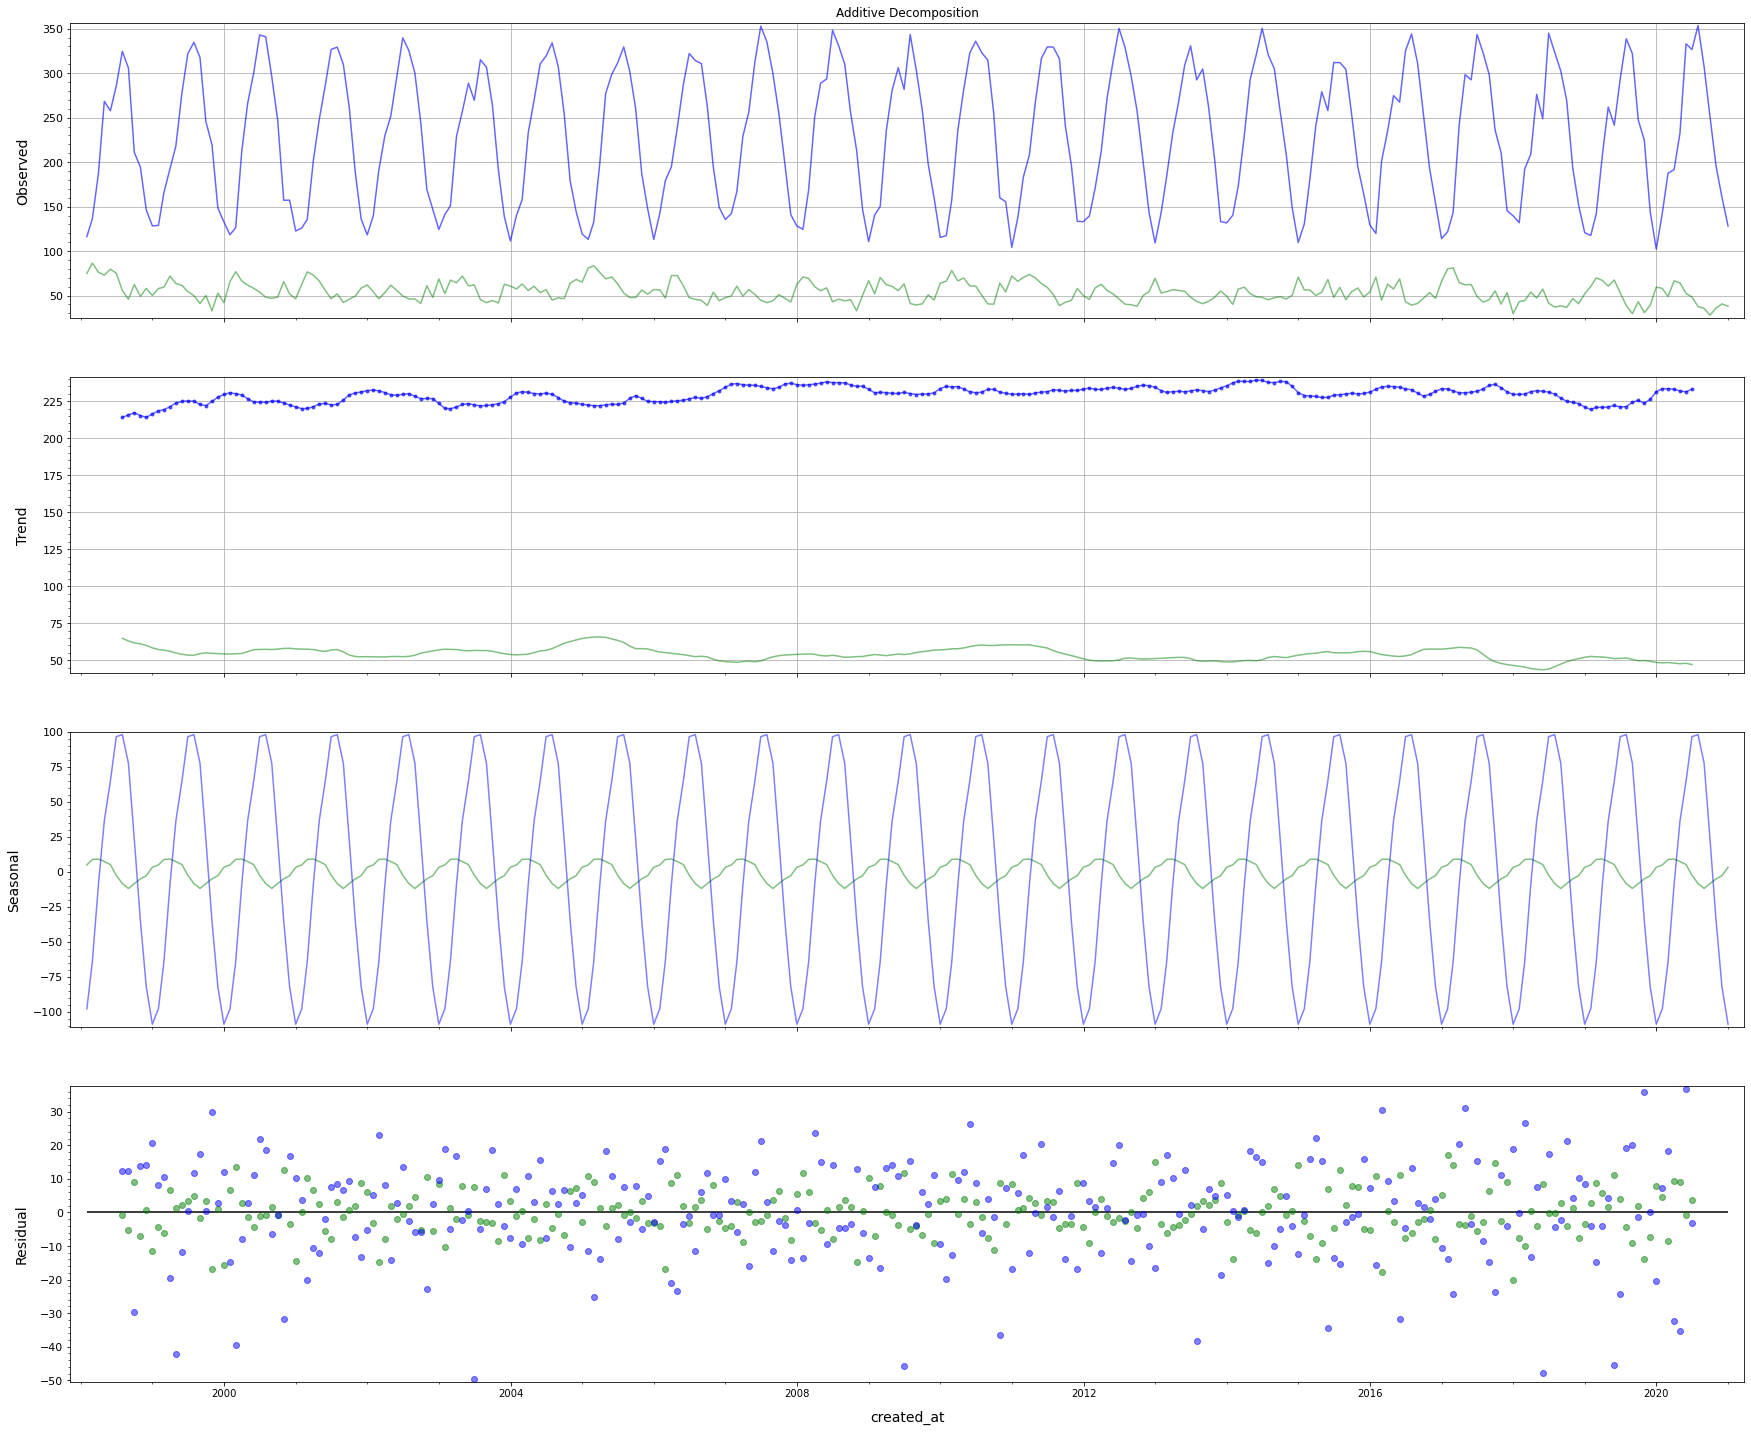

In [14]:
fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title("Additive Decomposition")

# ax[0].plot(decomp_e.observed.index, decomp_e.observed, '-', color='red', alpha=.7)
ax[0].plot(decomp_f.observed.index, decomp_f.observed, '-', color='green', alpha=.5)
# ax[0].plot(decomp_g.observed.index, decomp_g.observed, '-', color='orange', alpha=.9)
ax[0].plot(decomp_h.observed.index, decomp_h.observed, '-', color='blue', alpha=.6)
ax[0].minorticks_on()
ax[0].grid()
ax[0].set(ylabel="Observed")

# ax[1].plot(decomp_e.trend.index, decomp_e.trend, '-', color='red', alpha=.7)
ax[1].plot(decomp_f.trend.index, decomp_f.trend, '-', color='green', alpha=.5)
# ax[1].plot(decomp_g.trend.index, decomp_g.trend, '.-', color='orange', alpha=.9)
ax[1].plot(decomp_h.trend.index, decomp_h.trend, '.-', color='blue', alpha=.6)
ax[1].minorticks_on()
ax[1].grid()
ax[1].set(ylabel="Trend")

# ax[2].plot(decomp_e.seasonal.index, decomp_e.seasonal, '-', color='red', alpha=.7)
ax[2].plot(decomp_f.seasonal.index, decomp_f.seasonal, '-', color='green', alpha=.5)
# ax[2].plot(decomp_g.seasonal.index, decomp_g.seasonal, '-', color='orange', alpha=.7)
ax[2].plot(decomp_h.seasonal.index, decomp_h.seasonal, '-', color='blue', alpha=.5)
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")


# ax[3].plot(decomp_e.resid.index, decomp_e.resid, "o", color='red', alpha=.7)
ax[3].plot(decomp_f.resid.index, decomp_f.resid, "o", color='green', alpha=.5)
# ax[3].plot(decomp_g.resid.index, decomp_g.resid, "o", color='orange', alpha=.7)
ax[3].plot(decomp_h.resid.index, decomp_h.resid, "o", color='blue', alpha=.5)
ax[3].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()